In [1]:
import logging
import os
from pprint import pprint
import shutil
from tqdm import tqdm

import tensorflow as tf

from ssd.common.callbacks import CallbackBuilder
from ssd.common.distribute import get_strategy
from ssd.common.config import load_config
from ssd.common.viz_utils import draw_boxes_cv2, imshow
from ssd.data.dataset_builder import DatasetBuilder
from ssd.losses.multibox_loss import MultiBoxLoss
from ssd.models.ssd_model import SSDModel

logger = tf.get_logger()
logger.setLevel(logging.INFO)

logger.info('version: {}'.format(tf.__version__))

INFO:tensorflow:version: 2.2.0-rc3


In [3]:
# !python ssd/scripts/calculate_feature_shapes.py --image_height 300 --image_width 300 --num_feature_maps 6
# !python ssd/scripts/calculate_scales.py -n 6 --s_first 0.1 --smin 0.2 --smax 0.9
# !python check_matching.py ssd/cfg/shapes_dataset.yaml

In [4]:
config = load_config('ssd/cfg/shapes_dataset.yaml')

strategy = get_strategy(config)

epochs = config['epochs']

lr = config['base_lr']
lr = config['base_lr']
lr = lr if not config['scale_lr'] else lr * strategy.num_replicas_in_sync

batch_size = config['batch_size']
batch_size = batch_size if not config[
    'scale_batch_size'] else batch_size * strategy.num_replicas_in_sync
config['batch_size'] = batch_size

train_steps = config['train_images'] // config['batch_size']
val_steps = config['val_images'] // config['batch_size']

print('\n')
pprint(config, width=120, compact=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Running with MirroredStrategy on 4 GPU's 


{'aspect_ratios': ((0.5, 1, 2), (0.333, 0.5, 1, 2, 3), (0.333, 0.5, 1, 2, 3), (0.333, 0.5, 1, 2, 3), (0.5, 1, 2),
                   (0.5, 1, 2)),
 'augment_val_dataset': True,
 'backbone': 'resnet_50_v2',
 'base_lr': 1e-05,
 'batch_size': 32,
 'brightness_max_delta': 0.2,
 'classes': ('circle', 'rectangle'),
 'clear_previous_runs': True,
 'clip_default_boxes': False,
 'cls_loss_weight': 1.0,
 'contrast_lower': 0.5,
 'contrast_upper': 1.5,
 'epochs': 10,
 'feature_shapes': ((38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)),
 'freeze_bn': True,
 'image_height': 300,
 'image_width': 300,
 'l2_regularization': 0.0001,
 'loc_loss_weight': 1.0,
 'loc_variance': (0.1, 0.1, 0.2, 0.2),
 'ma

In [5]:
with strategy.scope():
    train_dataset = DatasetBuilder('train', config)
    val_dataset = DatasetBuilder('val', config)

    loss_fn = MultiBoxLoss(config)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    callbacks_list = CallbackBuilder('shapes_dataset_demo',
                                     config).get_callbacks()

    model = SSDModel(config)
    model.compile(loss_fn=loss_fn, optimizer=optimizer)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [6]:
if config['clear_previous_runs']:
    if config['use_tpu']:
        logger.warning('Skipping GCS Bucket')
    else:
        try:
            shutil.rmtree(os.path.join(config['model_dir']))
            logger.info('Cleared existing model files\n')
        except FileNotFoundError:
            logger.warning('mode_dir not found!')
            os.mkdir(config['model_dir'])

INFO:tensorflow:Cleared existing model files



In [7]:
model.fit(train_dataset.dataset,
          epochs=epochs,
          steps_per_epoch=train_steps,
          validation_data=val_dataset.dataset,
          validation_steps=val_steps,
          callbacks=callbacks_list)

with strategy.scope():
    save_path = os.path.join(config['model_dir'], 'final_weights', 'ssd_weights')
    logger.info('Saving final weights at in {}'.format(save_path))
    model.save_weights(save_path)

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 196 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 196 all-reduces with algorithm = nccl, num_packs = 1
312/312 [==============================] - ETA: 0s - loc_loss: 0.2781 - cls_loss: 1.6893 - loss: 1.9673 - l2_reg: 0.0098
Epoch 00001: val_loss improved from inf to 0.62436, saving model to model_files/checkpoints/shapes_dataset_demo_ssd_weights
312/312 [==============================] - 46s 148ms/step - loc_loss: 0.2775 - cls_loss: 1.6856 - loss: 1.9631 - l2_reg: 0.0098 - val_loc_loss: 0.0904 - val_cls_loss: 0.5340 - val_loss: 0.6244 - val_l2_reg: 0.0091
Epoch 2/10
312/312 [==============================] - ETA: 0s - loc_loss: 0.0782 - cls_loss: 0.4265 - loss: 0.5047 - l2_reg: 0.0086
Epoch 00002: val_loss improved from 0.62436 to 0.34579, saving model to model_files/checkpoints/shapes_dataset_demo_ssd_weights
312/312 [==============================] - 44s 141ms/step - loc_loss: 0.0781 - cls_loss: 0.4263 

In [13]:
with strategy.scope():
    best_weights = tf.train.latest_checkpoint(os.path.join(config['model_dir'], 'checkpoints'))
    model.load_weights(best_weights)
    logger.info('Loaded weights from {}'.format(best_weights))

INFO:tensorflow:Loaded weights from model_files/checkpoints/shapes_dataset_demo_ssd_weights


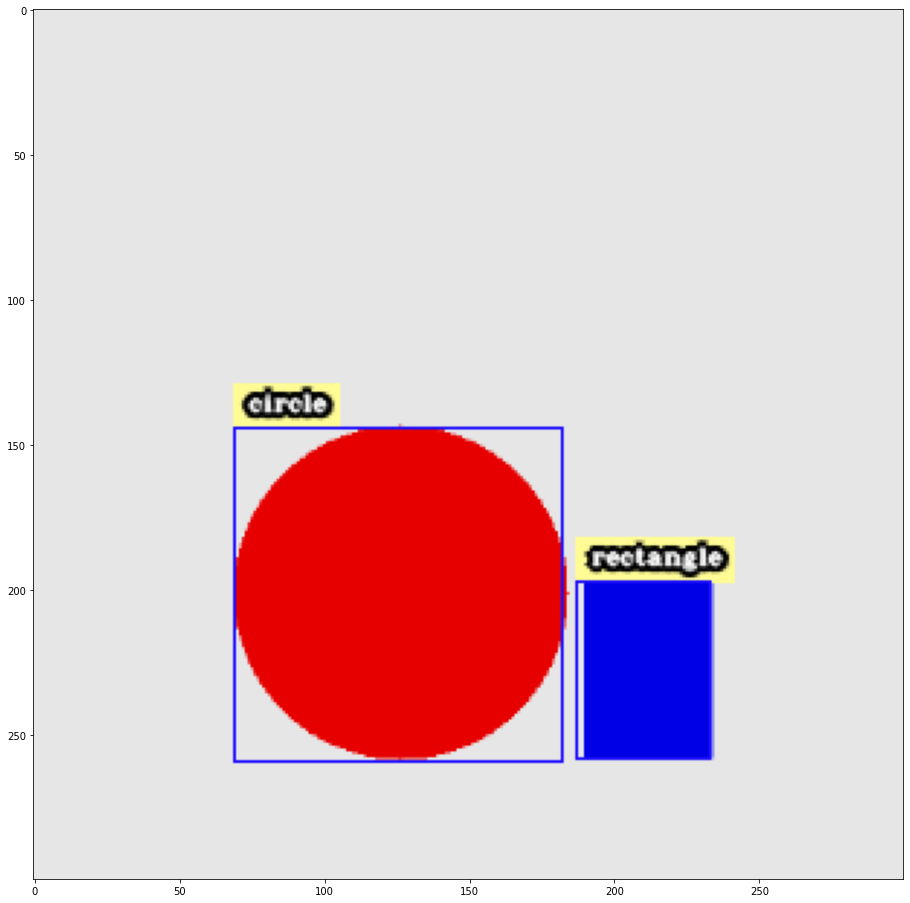

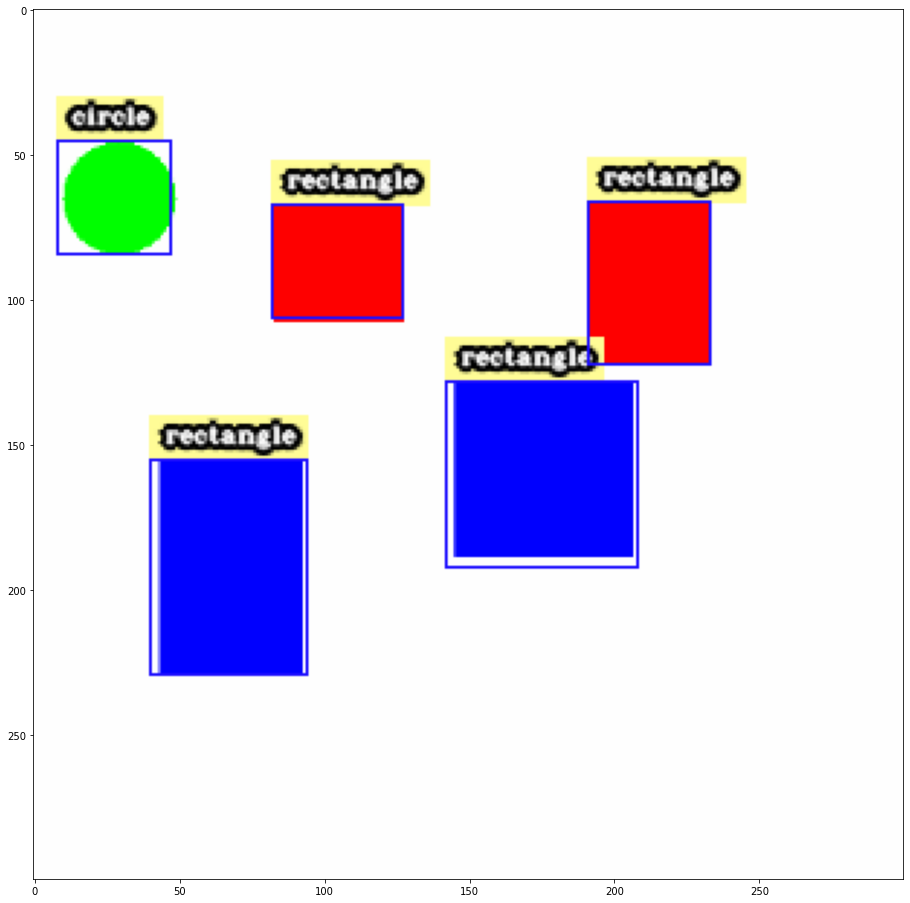

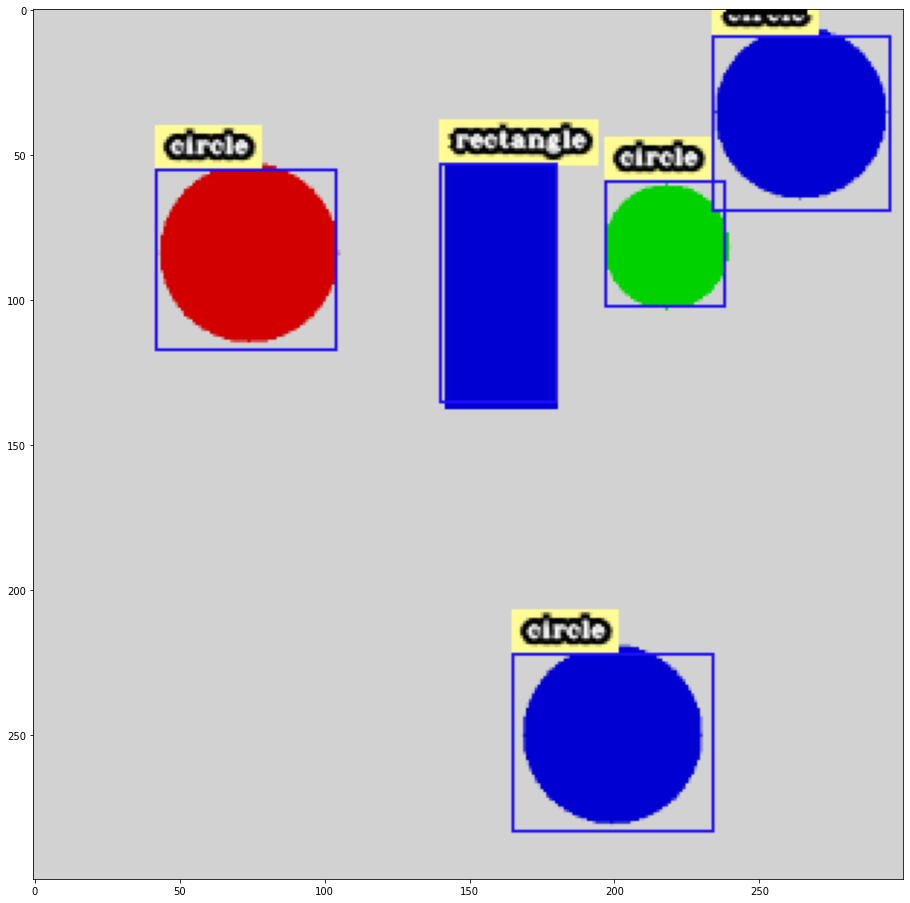

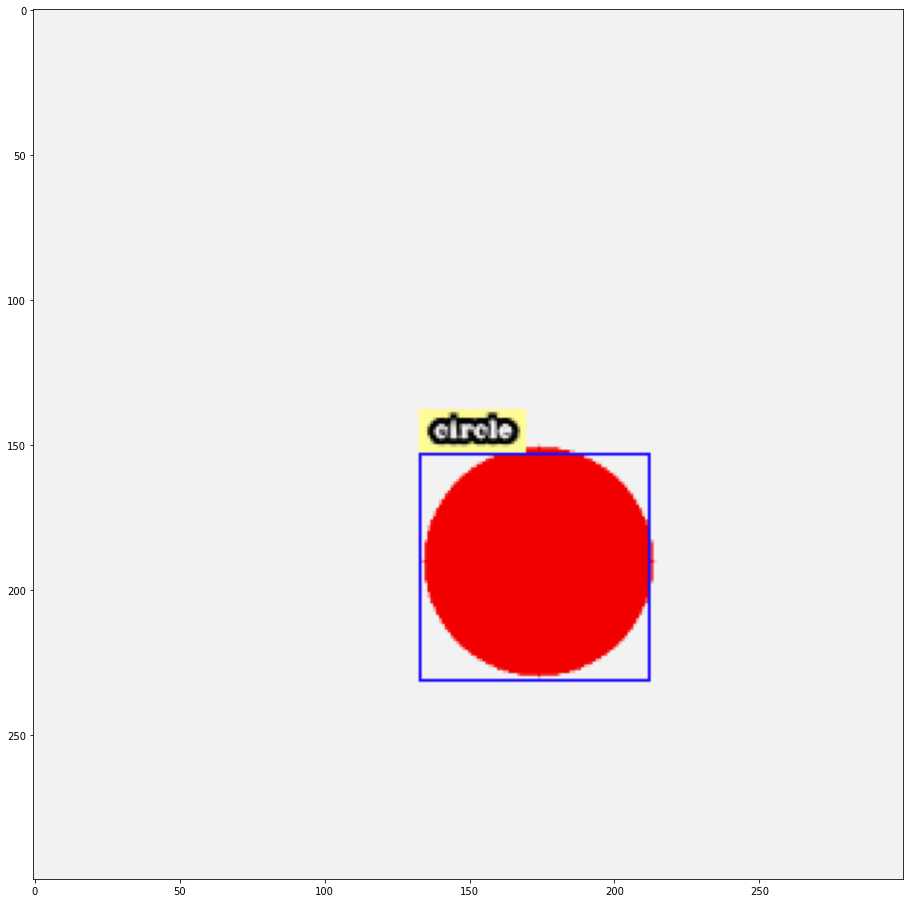

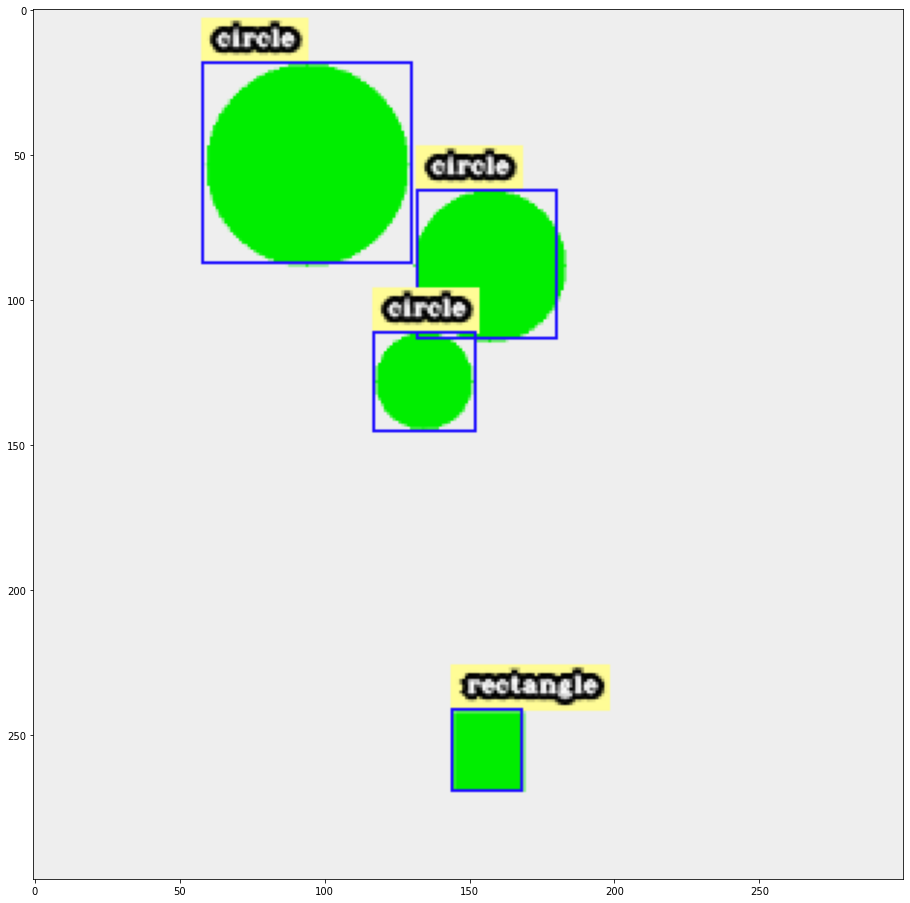

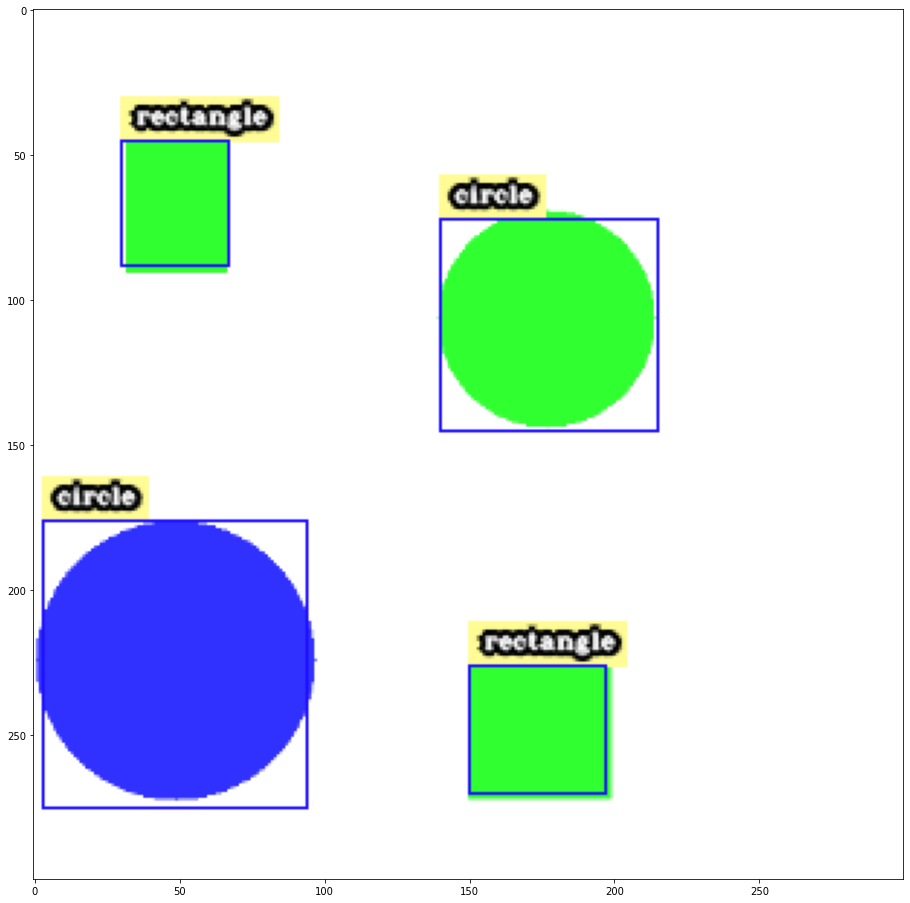

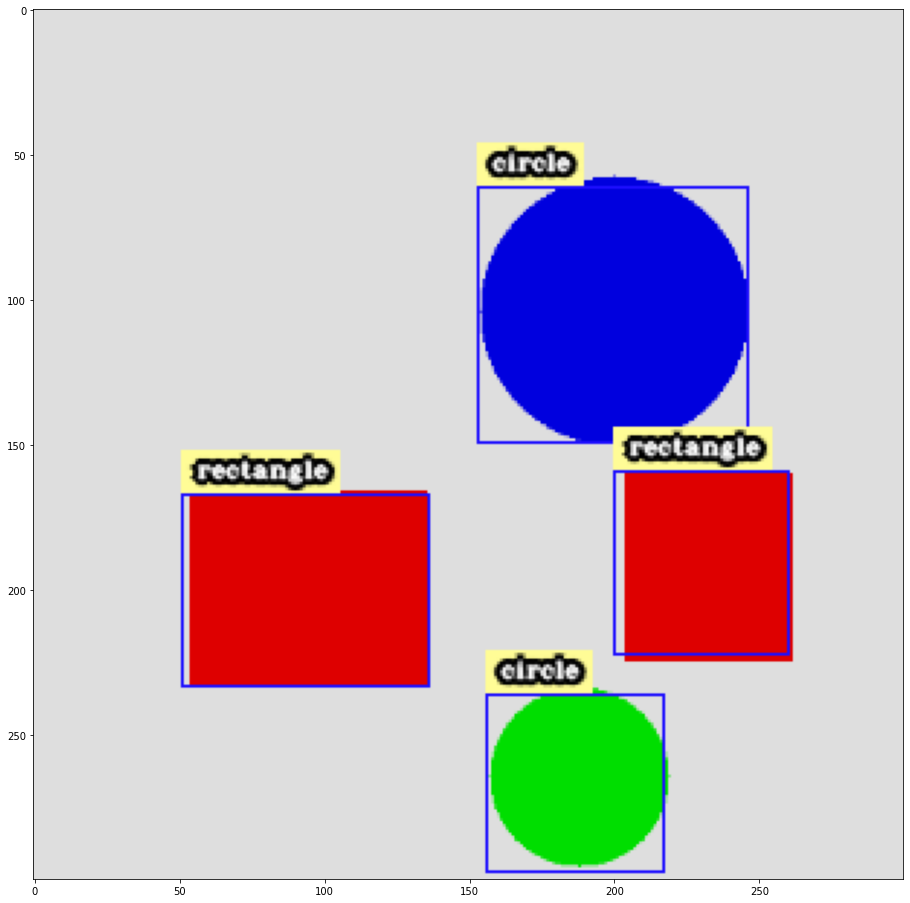

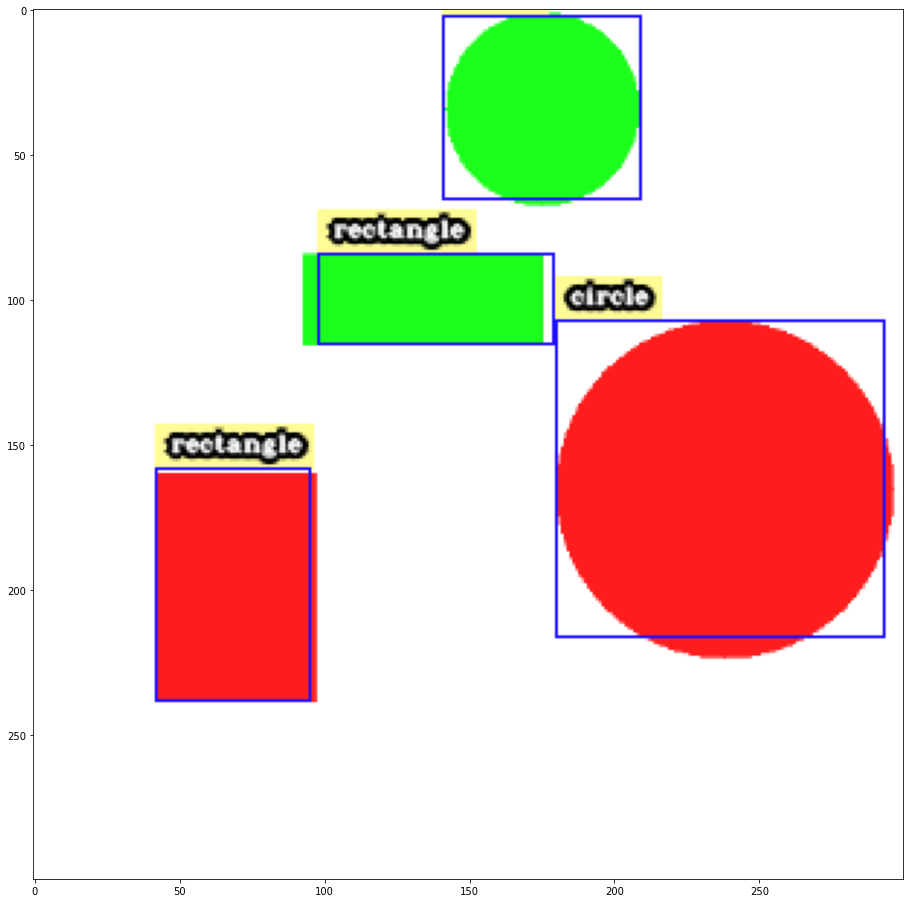

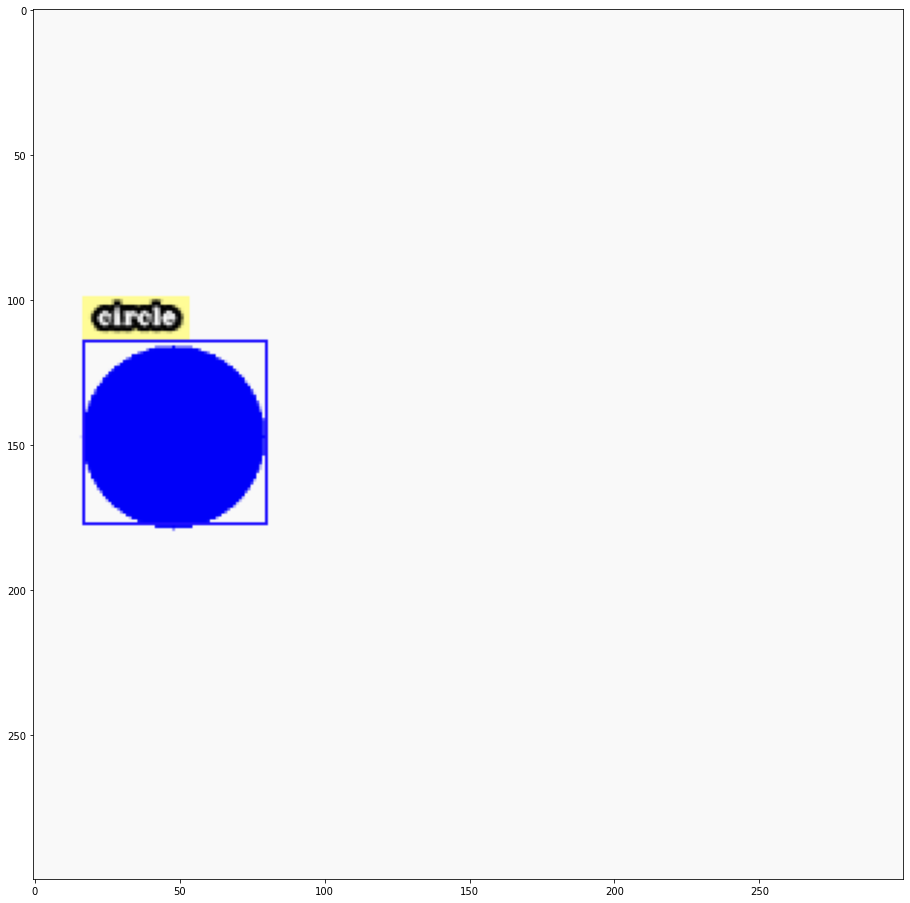

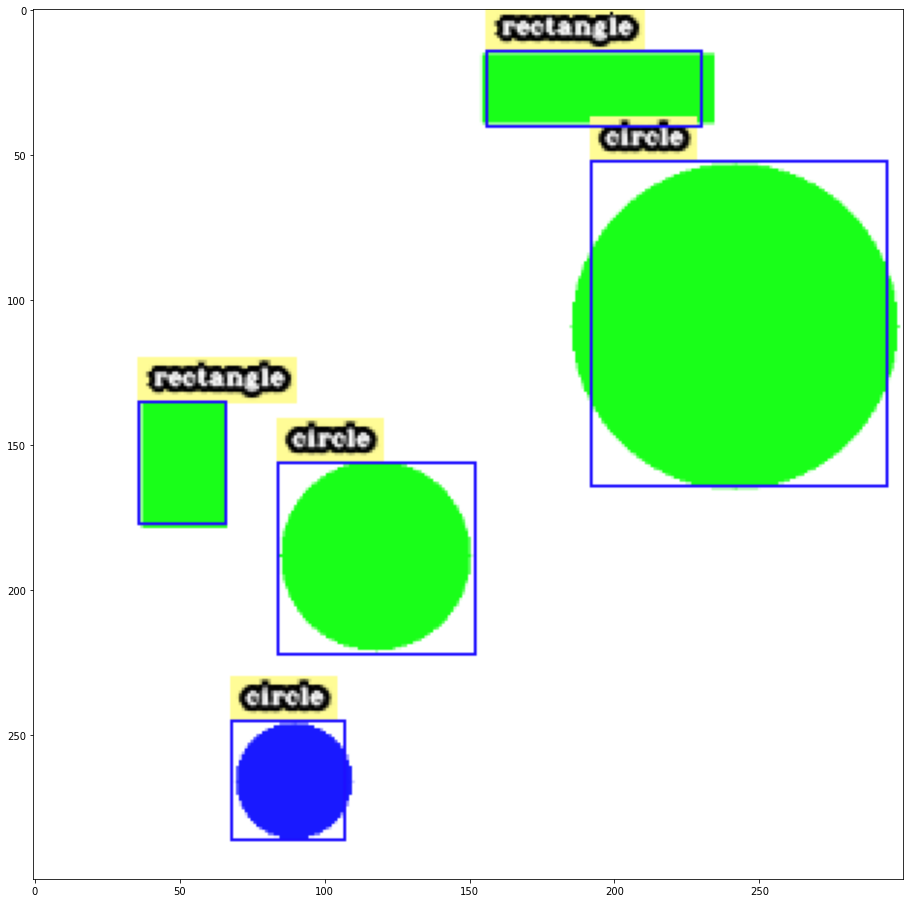

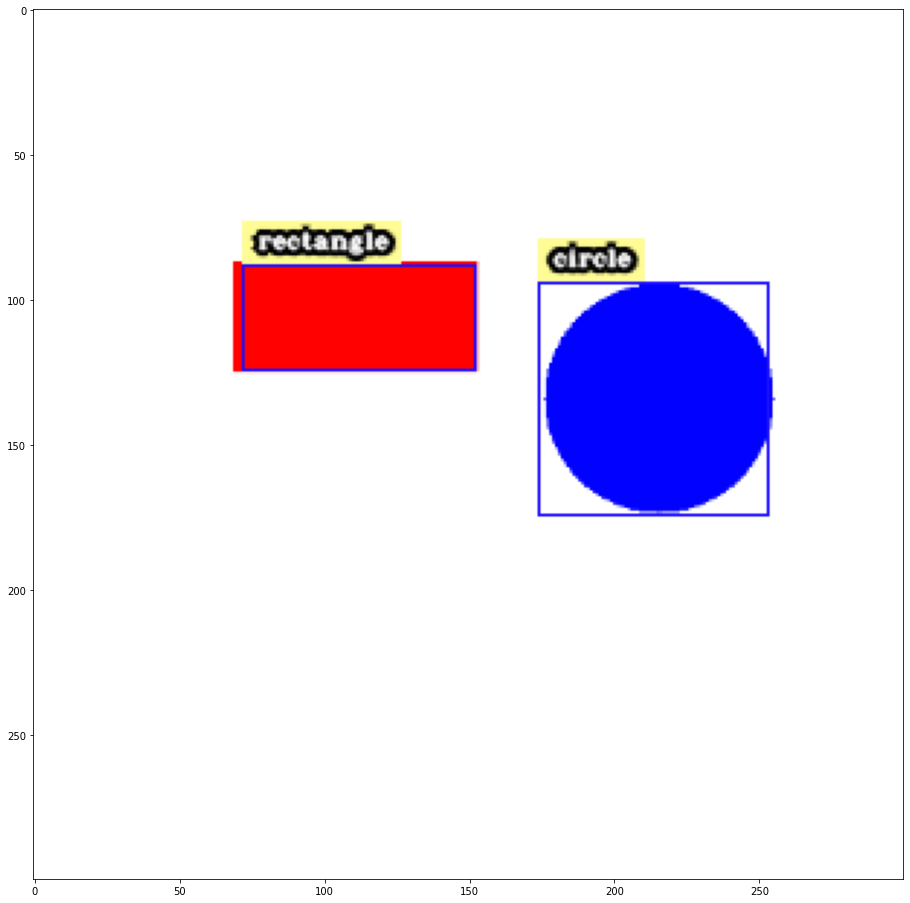

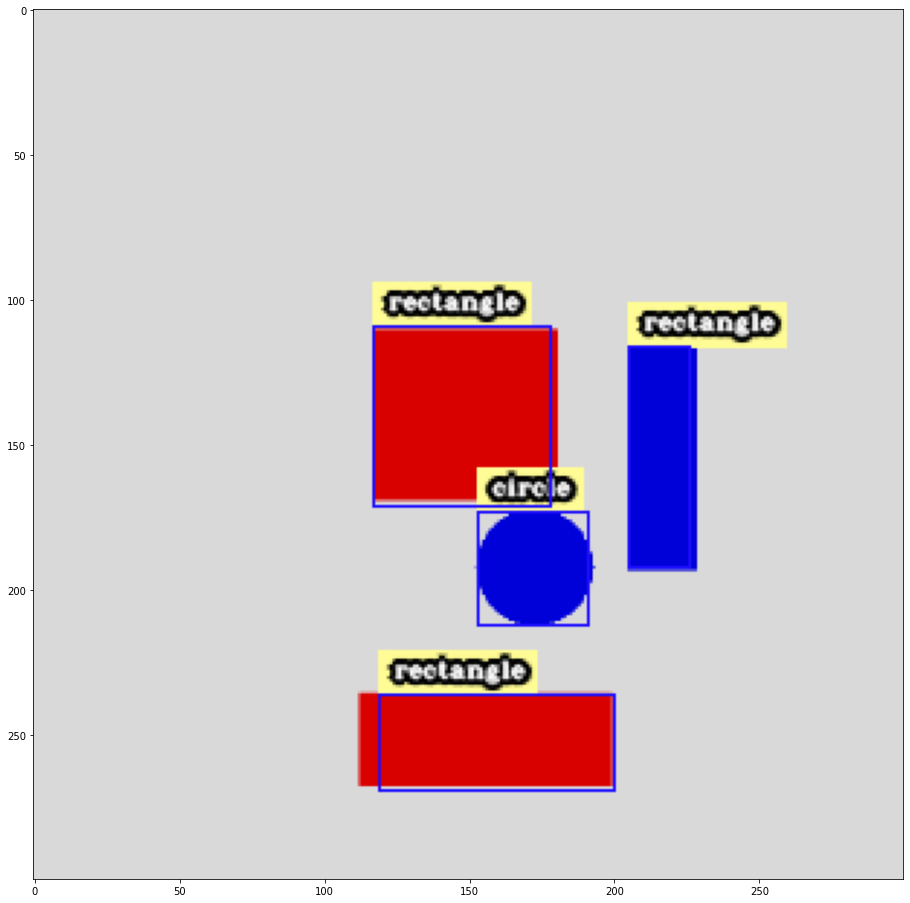

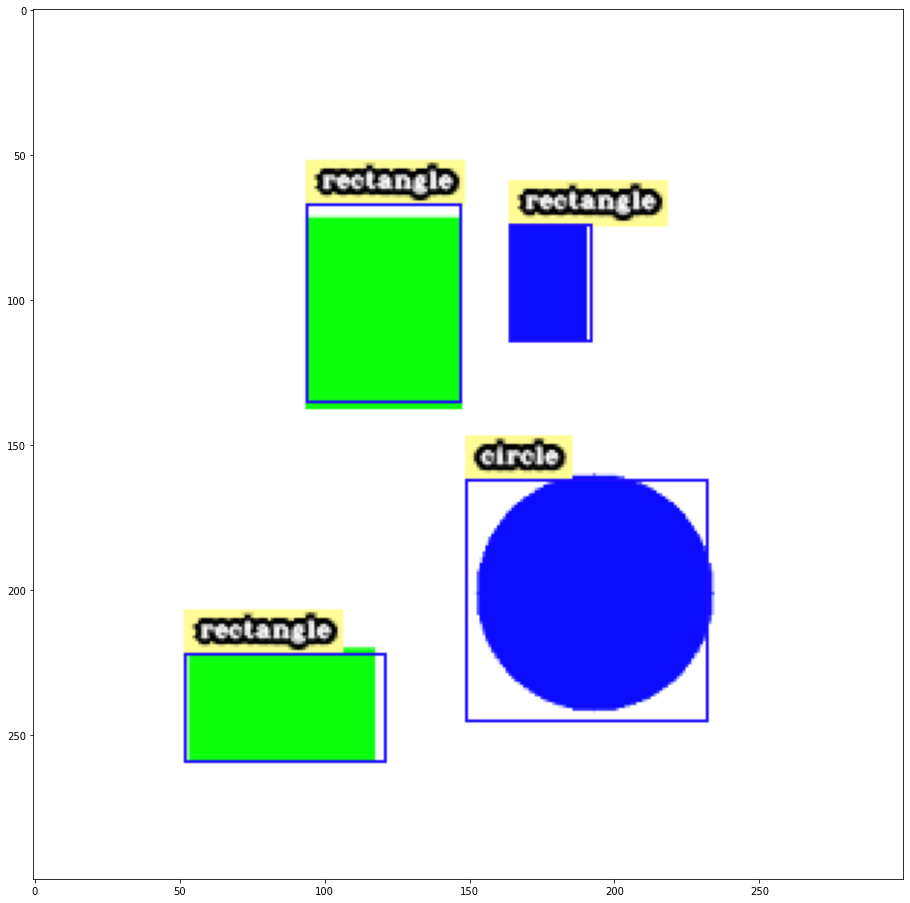

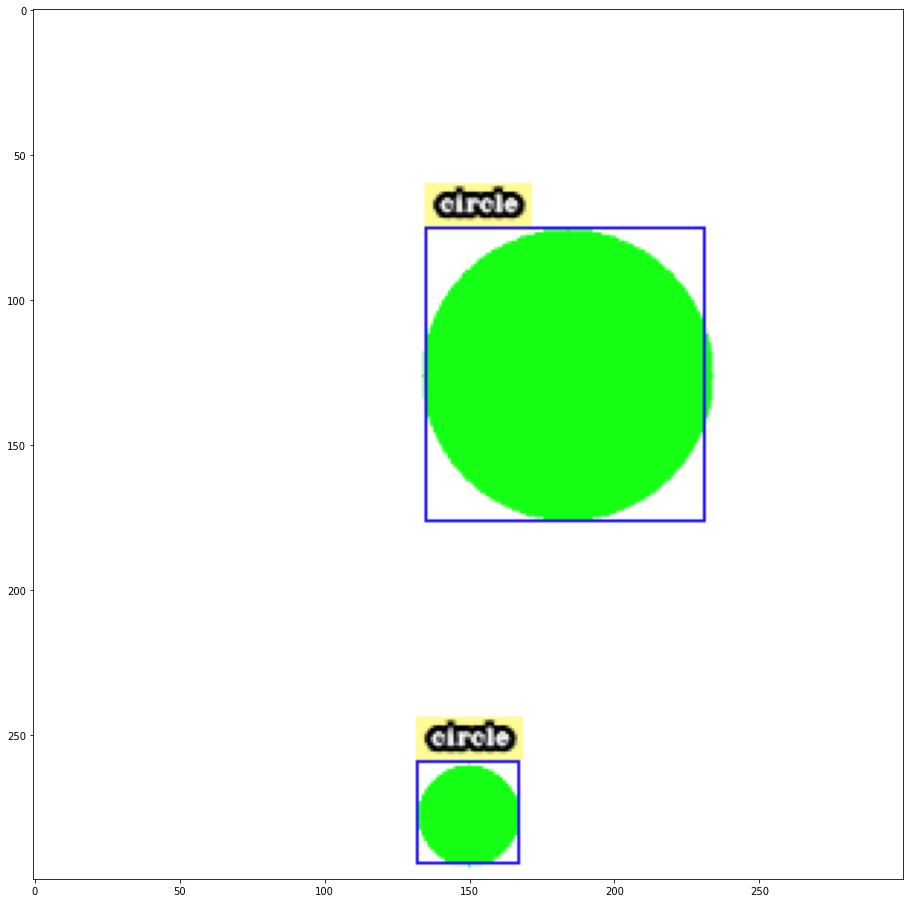

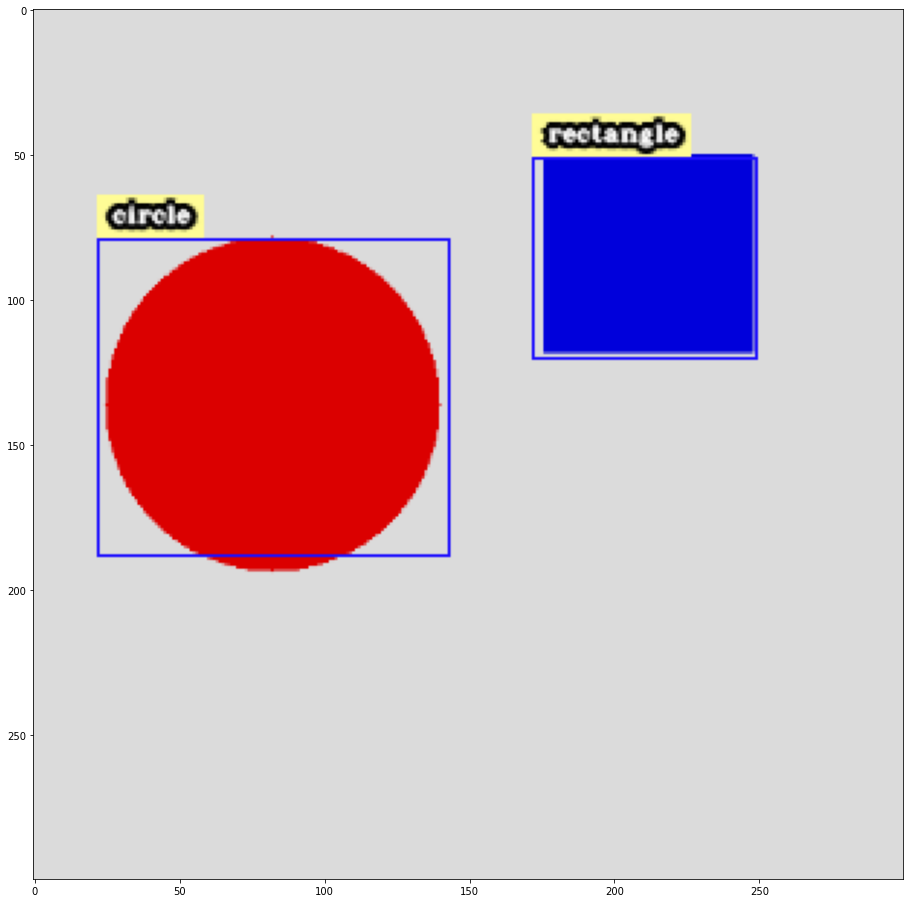

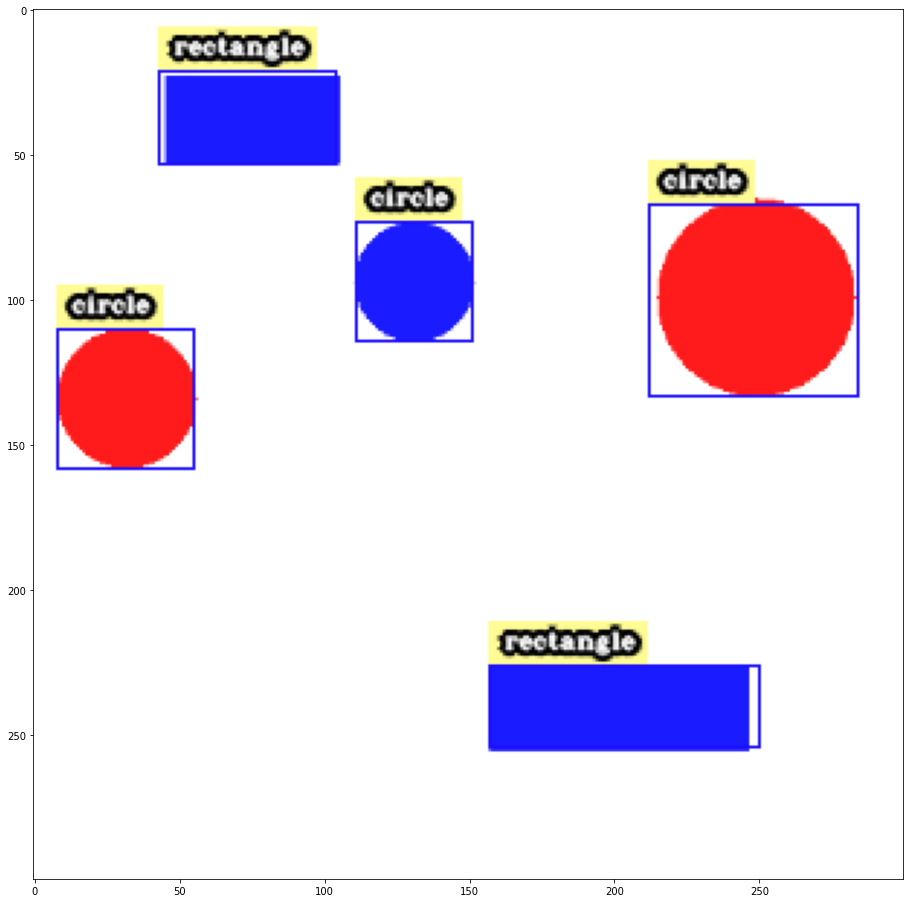

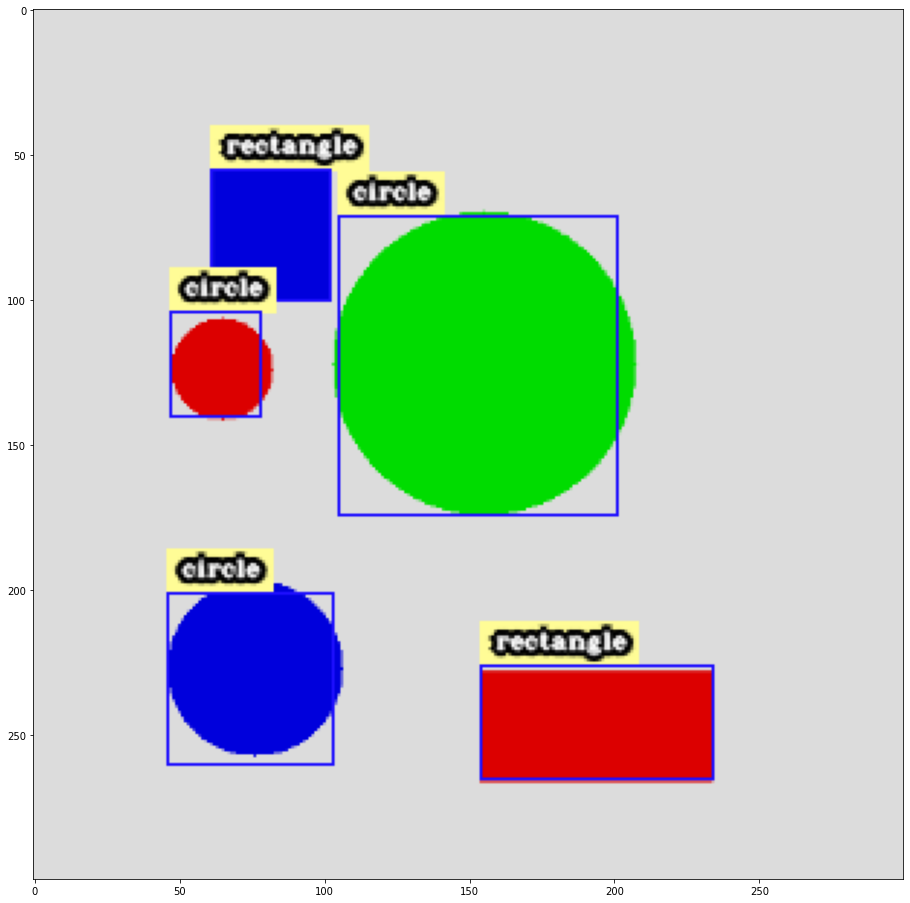

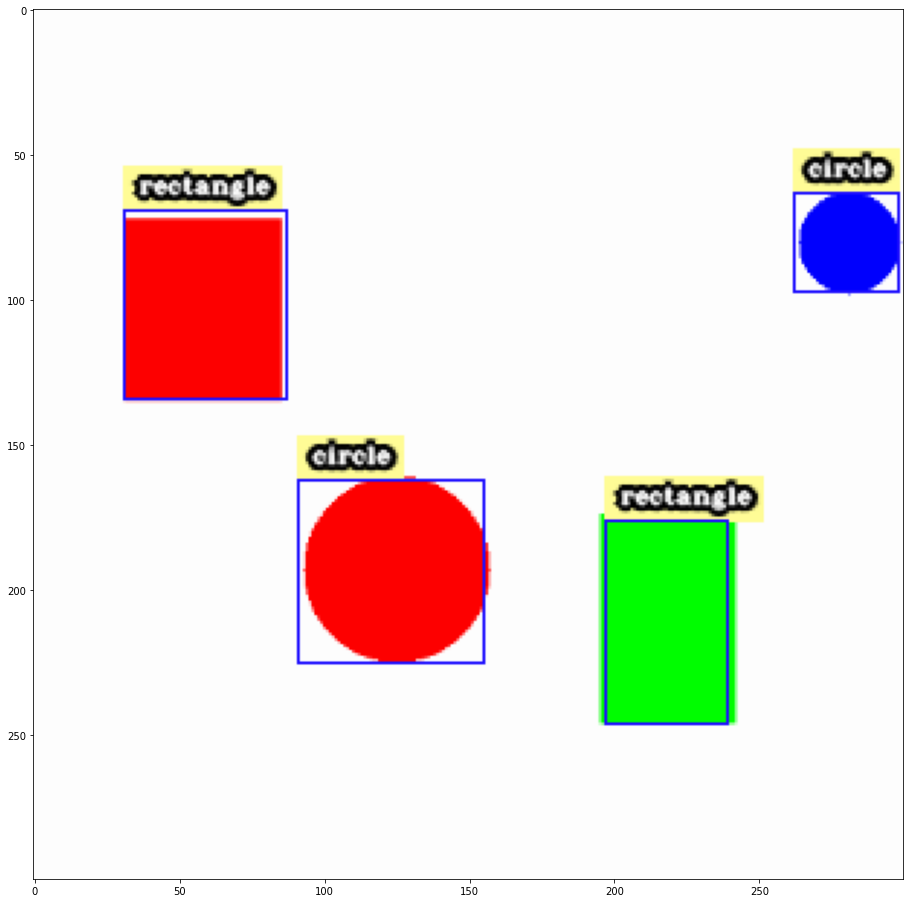

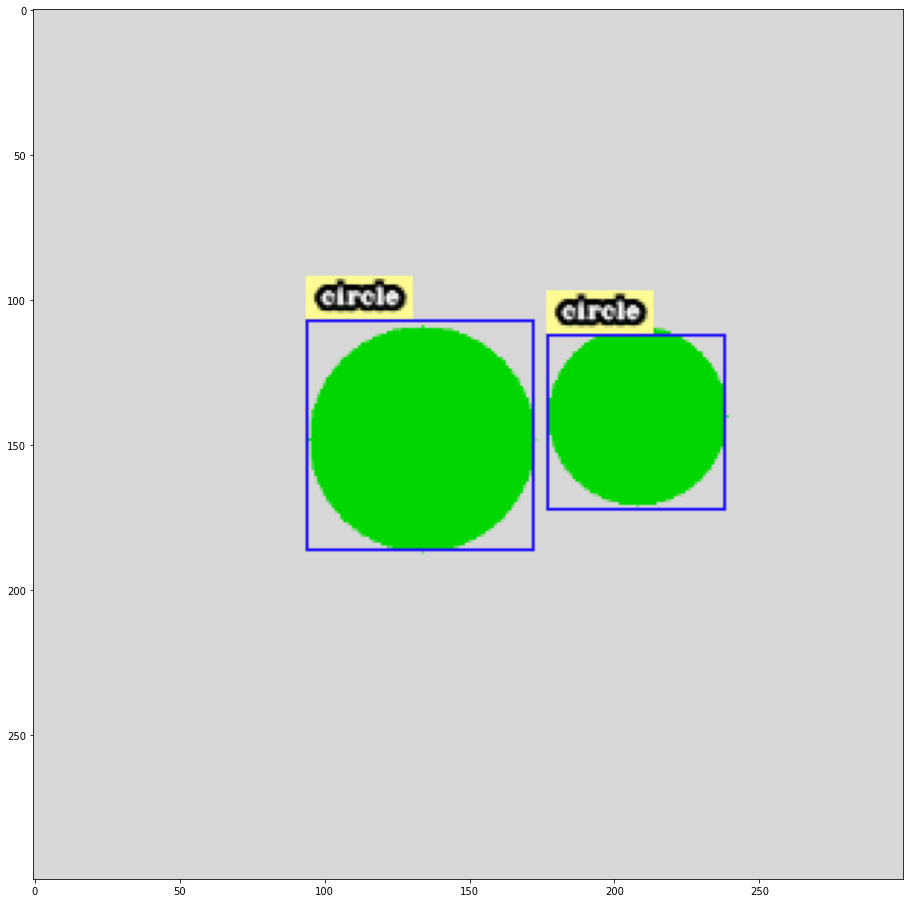

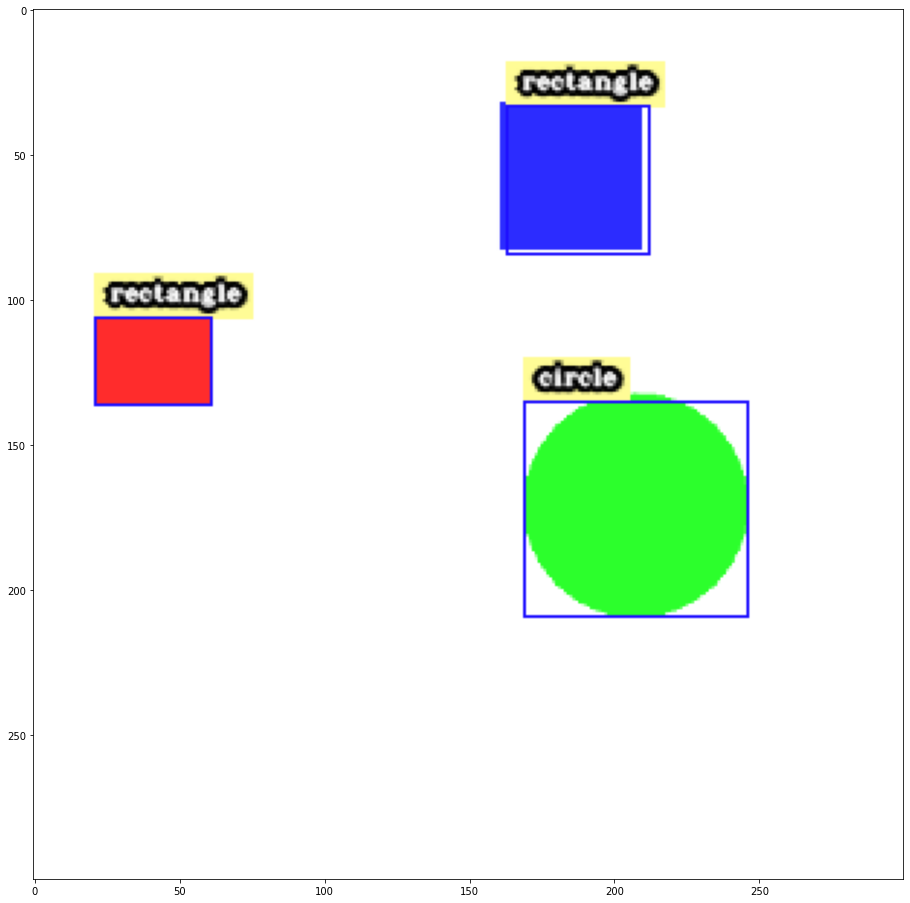

In [15]:
for images, _ in val_dataset.dataset.take(1):
    for i in range(images.shape[0]):
        if i == 20: break
        image = images[i]
        detections = model.get_detections(image[None, ...])
        image = image * 127.5 + 127.5
        
        categories = [config['classes'][cls_id] for cls_id in detections['cls_ids'].numpy()]
        image = draw_boxes_cv2(image, detections['boxes'], categories)
        imshow(image)